In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import Imputer,StandardScaler
from scipy.stats.stats import pearsonr
from sklearn.feature_selection import SelectKBest,SelectPercentile,RFE,RFECV,SelectFromModel
from sklearn.svm import SVR,SVC
from sklearn.linear_model import Lasso
from sklearn.svm import LinearSVR
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import seaborn as sns
import re
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


In [6]:
data=pd.read_csv("movie_metadata_new.csv")
data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,6900.0,3900.0,Zoe Saldana,5300.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,8200.0,7.9,1.78,33000.0
1,Color,Gore Verbinski,302.0,169.0,565.0,5000.0,Geoffrey Rush,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,2900.0,7.1,2.35,5200.0
2,Color,Sam Mendes,602.0,148.0,2200.0,1700.0,Christoph Waltz,8300.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,11000.0,6.8,2.35,86000.0
3,Color,Christopher Nolan,813.0,164.0,22000.0,27000.0,Gary Oldman,23000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,10000.0,8.5,2.35,164000.0
4,NaN,J.J. Abrams,NaN,NaN,14000.0,2000.0,Mark Hamill,11000.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,4400.0,7.1,NaN,263000.0


In [7]:
obj_col=['language','country','content_rating']

data[obj_col[1]].value_counts().index[0]

'USA'

In [8]:
def fill_non_num_mode(df,obj_col):
    for col in obj_col:
        mode=df[col].value_counts().index[0]
        df[col]=df[col].fillna(mode)
    return df

# return only n-1 col
def get_dummy_and_append(numeric_df,non_numeric_df):
    for col in non_numeric_df.columns:
        dummy_df=pd.get_dummies(non_numeric_df[col]).ix[:,0:-1]
        numeric_df=pd.concat([numeric_df, dummy_df], axis=1)
    return numeric_df

def split_data(x_data,y_data,size=0.1):
    return train_test_split(x_data,y_data,test_size=size)

# score_type accpet R^2, abs error
def train_eval_model(model,x_train,y_train,x_test,y_test,score_type="R^2"):
    model.fit(X=x_train,y=y_train)
    predicted_y_train = model.predict(x_train)
    predicted_y_test = model.predict(x_test)
    if score_type=="R^2":
        return [r2_score(y_train,predicted_y_train),r2_score(y_test,predicted_y_test)]
    elif score_type=='abs_error':
        return [mean_absolute_error(y_train,predicted_y_train),mean_absolute_error(y_test,predicted_y_test)]

In [9]:
obj_col=['language','country','content_rating']
data=fill_non_num_mode(data,obj_col)

In [10]:
numeric_data=data.select_dtypes(exclude=['object'])

In [11]:
score=numeric_data['imdb_score']
numeric_data=numeric_data.drop(['imdb_score'],axis=1)

In [12]:
imp = Imputer(missing_values="NaN",strategy="mean",axis=0)      #default values
numeric_data[numeric_data.columns]=imp.fit_transform(numeric_data)

In [13]:
scaler = StandardScaler()
numeric_data[numeric_data.columns] = scaler.fit_transform(numeric_data[numeric_data.columns])

In [14]:
final_data=get_dummy_and_append(numeric_data,data[obj_col])

In [15]:
low_covariance_1 = []
low_covariance_2 = []
low_covariance_15 = []
low_covariance_2g = []
for x in final_data.columns:
    z = (np.corrcoef(final_data[x],y=score))
    if(np.fabs(z[0,1]) < 0.1):
        low_covariance_1.append(x)
    elif(np.fabs(z[0,1]) < 0.15):
        low_covariance_15.append(x)
    elif(np.fabs(z[0,1])<0.2):
        low_covariance_2.append(x)
    else:
        low_covariance_2g.append(x)

In [16]:
print low_covariance_2g, "\n", low_covariance_2, "\n", low_covariance_15, "\n", low_covariance_1

['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'num_voted_users', 'num_user_for_reviews', 'title_year', 'movie_facebook_likes'] 
['gross'] 
['actor_1_facebook_likes', 'English', 'UK', 'USA', 'PG-13', 'TV-MA'] 
['actor_3_facebook_likes', 'cast_total_facebook_likes', 'facenumber_in_poster', 'budget', 'actor_2_facebook_likes', 'aspect_ratio', 'Aboriginal', 'Arabic', 'Aramaic', 'Bosnian', 'Cantonese', 'Chinese', 'Czech', 'Danish', 'Dari', 'Dutch', 'Dzongkha', 'Filipino', 'French', 'German', 'Greek', 'Hebrew', 'Hindi', 'Hungarian', 'Icelandic', 'Indonesian', 'Italian', 'Japanese', 'Kannada', 'Kazakh', 'Korean', 'Mandarin', 'Maya', 'Mongolian', 'None', 'Norwegian', 'Panjabi', 'Persian', 'Polish', 'Portuguese', 'Romanian', 'Russian', 'Slovenian', 'Spanish', 'Swahili', 'Swedish', 'Tamil', 'Telugu', 'Thai', 'Urdu', 'Vietnamese', 'Afghanistan', 'Argentina', 'Aruba', 'Australia', 'Bahamas', 'Belgium', 'Brazil', 'Bulgaria', 'Cambodia', 'Cameroon', 'Canada', 'Chile', 'China', 'Co

In [17]:
final_col=['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'num_voted_users', 'num_user_for_reviews', 'title_year', 'movie_facebook_likes','gross','actor_1_facebook_likes', 'English', 'UK', 'USA', 'PG-13', 'TV-MA', 'cast_total_facebook_likes', 'budget', 'actor_2_facebook_likes']

In [18]:
final_data=final_data[final_col]

In [19]:
training_x,test_x,training_Y,test_y = split_data(final_data,score)

In [20]:
# svr with diff kernel
svr_linear_model = LinearSVR()
svr_model = SVR(kernel='rbf') #default
svr_poly_model = SVR(kernel="poly") #default degree is 3

# knn with diff n, uniform
default_knn = KNeighborsRegressor(n_neighbors=5#,weights='distance')
knn_10 = KNeighborsRegressor(n_neighbors=10)#,weights='distance')
knn_20 = KNeighborsRegressor(n_neighbors=20)#,weights='distance')
# knn with diff n, distance
#distance

In [21]:
model_list=[svr_linear_model,svr_model,svr_poly_model,default_knn,knn_10,knn_20]

In [22]:
for model in model_list:
    temp=train_eval_model(model,training_x,training_Y,test_x,test_y,score_type="abs_error")
    model_name=re.search('(.*)\(',str(model)).group(1)
    print(str(model_name)," training error", str(temp[0]))
    print(str(model_name)," testing error", str(temp[1]))

('LinearSVR', ' training error', '0.685994716388')
('LinearSVR', ' testing error', '0.657552658166')
('SVR', ' training error', '0.560693814473')
('SVR', ' testing error', '0.562957341418')
('SVR', ' training error', '0.633551031749')
('SVR', ' testing error', '0.645355270442')
('KNeighborsRegressor', ' training error', '0.551432349052')
('KNeighborsRegressor', ' testing error', '0.642178217822')
('KNeighborsRegressor', ' training error', '0.60530850595')
('KNeighborsRegressor', ' testing error', '0.635940594059')
('KNeighborsRegressor', ' training error', '0.640866020273')
('KNeighborsRegressor', ' testing error', '0.647673267327')


In [27]:
train_error_list=[]
test_error_list=[]
train_error_list2=[]
test_error_list2=[]

for i in range(2,100,1):
    model = KNeighborsRegressor(n_neighbors=i)#,weights='distance')
    temp=train_eval_model(model,training_x,training_Y,test_x,test_y,score_type="abs_error")
    train_error_list.append(temp[0])
    test_error_list.append(temp[1])
    
    model = KNeighborsRegressor(n_neighbors=i,weights='distance')
    temp=train_eval_model(model,training_x,training_Y,test_x,test_y,score_type="abs_error")
    train_error_list2.append(temp[0])
    test_error_list2.append(temp[1])


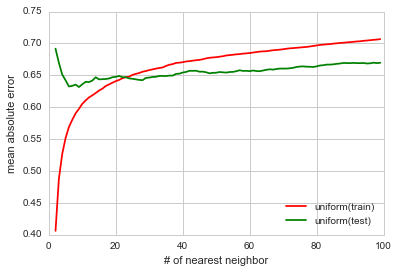

In [28]:
sns.set_style("whitegrid")
line1,=plt.plot(np.linspace(2,99,98),train_error_list,'r',label='uniform(train)')
line2,=plt.plot(np.linspace(2,99,98),test_error_list,'g',label='uniform(test)')

plt.legend(handles=[line1,line2],loc=4)
plt.xlabel('# of nearest neighbor')
plt.ylabel('mean absolute error')


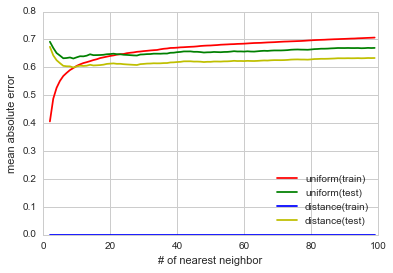

In [29]:
sns.set_style("whitegrid")
line1,=plt.plot(np.linspace(2,99,98),train_error_list,'r',label='uniform(train)')
line2,=plt.plot(np.linspace(2,99,98),test_error_list,'g',label='uniform(test)')
line3,=plt.plot(np.linspace(2,99,98),train_error_list2,'b',label='distance(train)')
line4,=plt.plot(np.linspace(2,99,98),test_error_list2,'y',label='distance(test)')
         
plt.legend(handles=[line1,line2,line3,line4],loc=4)
plt.xlabel('# of nearest neighbor')
plt.ylabel('mean absolute error')


In [26]:
sns.distplot(predicted_y,hist=True,rug=True,color="red").legend()
sns.distplot(test_y,hist=True,rug=True,color="green").legend()

NameError: name 'predicted_y' is not defined